In [3]:
# Deps (uncomment if needed)
# !pip install --quiet requests python-dotenv tqdm
# OpenAI (judge):
# !pip install --quiet openai>=1.40.0
# Vertex AI (judge):
# !pip install --quiet google-cloud-aiplatform>=1.63.0 vertexai>=1.63.0

import os
from pathlib import Path

# Ensure the notebook can find the Vertex credentials even when started from evaluation/
project_root = Path.cwd().resolve().parent
creds_path = project_root / 'secrets' / 'gcp.json'
if creds_path.exists():
    os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = str(creds_path)
    print('Using GOOGLE_APPLICATION_CREDENTIALS =', creds_path)
else:
    print('Credential file not found at', creds_path)

import json
import textwrap
import time
from collections import Counter
from dataclasses import dataclass
from typing import Any, Dict, Iterable, List, Optional

import requests
from dotenv import load_dotenv
from tqdm import tqdm

load_dotenv()

API_URL = os.getenv("EVAL_API_URL", "http://localhost:8000")
TOP_K = int(os.getenv("EVAL_TOP_K", "20"))
WINDOW_SIZE = int(os.getenv("EVAL_WINDOW_SIZE", "0"))
QUESTIONS_PATH = Path(os.getenv("EVAL_QUESTIONS_PATH", "evaluation_questions.json"))
OUTPUT_PATH = Path(os.getenv("EVAL_RESULTS_PATH", "judge_results.json"))
COUNT_LIMIT = int(os.getenv("EVAL_COUNT", "0"))
JUDGE_PROVIDER = os.getenv("JUDGE_PROVIDER", "auto")
OPENAI_MODEL = os.getenv("OPENAI_JUDGE_MODEL", "gpt-4o-mini")
VERTEX_MODEL = os.getenv("VERTEX_JUDGE_MODEL", "gemini-2.5-flash")

print("API_URL =", API_URL)
print("Top K =", TOP_K, "Window size =", WINDOW_SIZE)
print("Questions path =", QUESTIONS_PATH)
print("Output path =", OUTPUT_PATH)
print("Limit =", COUNT_LIMIT if COUNT_LIMIT else "all")
print("Judge provider =", JUDGE_PROVIDER)


Using GOOGLE_APPLICATION_CREDENTIALS = C:\Development\nlp-project\secrets\gcp.json
API_URL = http://localhost:8000
Top K = 20 Window size = 0
Questions path = evaluation_questions.json
Output path = judge_results.json
Limit = all
Judge provider = auto


In [2]:
@dataclass
class JudgeResult:
    index: int
    evaluation_id: str
    question: str
    topic: Optional[str]
    scenario: Optional[str]
    has_scenario: bool
    judge_choice: str
    chosen_method: Optional[str]
    optionA_method: Optional[str]
    optionB_method: Optional[str]

    def as_dict(self) -> Dict[str, Any]:
        return {
            "index": self.index,
            "evaluation_id": self.evaluation_id,
            "question": self.question,
            "topic": self.topic,
            "scenario": self.scenario,
            "has_scenario": self.has_scenario,
            "judge_choice": self.judge_choice,
            "chosen_method": self.chosen_method,
            "optionA_method": self.optionA_method,
            "optionB_method": self.optionB_method,
        }


class Judge:
    """Thin wrapper around OpenAI or Vertex AI judges."""

    def __init__(
        self,
        provider: str = "auto",
        openai_model: str = "gpt-4o-mini",
        vertex_model: str = "gemini-2.5-flash",
    ):
        provider = (provider or "auto").lower()
        self.provider = "noop"
        self.openai_model = openai_model
        self.vertex_model = vertex_model
        self.client: Any = None

        if provider in {"vertex", "auto"}:
            client = self._try_vertex()
            if client is not None:
                self.provider = "vertex"
                self.client = client
                return
            if provider == "vertex":
                raise RuntimeError("Vertex judge requested but Vertex AI credentials are not configured.")

        if provider in {"openai", "auto"}:
            client = self._try_openai()
            if client is not None:
                self.provider = "openai"
                self.client = client
                return
            if provider == "openai":
                raise RuntimeError("OpenAI judge requested but OpenAI credentials are not configured.")

        self.provider = "noop"

    def _try_vertex(self):
        try:
            import vertexai
            from vertexai.generative_models import GenerativeModel  # type: ignore
        except Exception:
            return None

        credentials_path = os.getenv("GOOGLE_APPLICATION_CREDENTIALS")
        if credentials_path and not Path(credentials_path).exists():
            print("Cant find file")
            return None

        project = os.getenv("GCP_PROJECT")
        if not project:
            return None
        location = os.getenv("GCP_LOCATION", "europe-west4")
        try:
            vertexai.init(project=project, location=location)
            return GenerativeModel(self.vertex_model)
        except Exception:
            return None

    def _try_openai(self):
        try:
            from openai import OpenAI  # type: ignore
        except Exception:
            return None
        try:
            return OpenAI()
        except Exception:
            return None

    @staticmethod
    def _render_prompt(question: str, opt_a: Dict[str, Any], opt_b: Dict[str, Any]) -> str:
        def _srcs(srcs: Iterable[Dict[str, Any]], max_items: int = 2, max_chars: int = 600) -> str:
            lines: List[str] = []
            for idx, src in enumerate(srcs):
                content = (src.get("content") or "")[:max_chars].replace("", " ")
                lines.append(f"[{idx + 1}] {content}")
                if idx + 1 >= max_items:
                    break
            return "".join(lines) if lines else "(geen bronnen beschikbaar)"

        prompt = textwrap.dedent(
            f"""
            Je bent een onpartijdige evaluator. Kies welke optie het beste juridische antwoord geeft op de vraag.
            Beoordeel op: feitelijke juistheid, juridische onderbouwing (met bronnen), relevantie en duidelijkheid.
            Als beide ongeveer even (on)geschikt zijn of niet te beoordelen is, kies 'N'.

            Geef ALLEEN exact één teken als output: A, B of N.

            Vraag:
            {question}

            Optie A (antwoord):
            {opt_a.get('answer', '')}
            Bronnen A:
            {_srcs(opt_a.get('sources', []))}

            Optie B (antwoord):
            {opt_b.get('answer', '')}
            Bronnen B:
            {_srcs(opt_b.get('sources', []))}

            Antwoord strikt met: A of B of N
            """
        ).strip()
        return prompt

    @staticmethod
    def _coerce(raw: Optional[str]) -> str:
        token = (raw or "").strip().upper()
        if token.startswith("A"):
            return "A"
        if token.startswith("B"):
            return "B"
        if token.startswith("N"):
            return "N"
        print("Waarschuwing: ongeldig antwoord van judge:", repr(raw))
        return "N"

    def judge(self, question: str, option_a: Dict[str, Any], option_b: Dict[str, Any]) -> str:
        if self.provider == "noop":
            return "N"

        prompt = self._render_prompt(question, option_a, option_b)
        if self.provider == "openai":
            response = self.client.chat.completions.create(
                model=self.openai_model,
                temperature=0.0,
                messages=[
                    {"role": "system", "content": "You must answer with exactly one letter: A, B, or N."},
                    {"role": "user", "content": prompt},
                ],
            )
            raw = response.choices[0].message.content
            return self._coerce(raw)

        response = self.client.generate_content(
            ["Je moet exact één letter antwoorden: A, B of N.", prompt],
            generation_config={"temperature": 0.0},
        )
        raw = getattr(response, "text", None)
        return self._coerce(raw)


In [3]:
def compose_question(base: str, scenario: str) -> str:
    base = (base or "").strip()
    scenario = (scenario or "").strip()
    if scenario and scenario not in base:
        return f"{base}\n\nScenario: {scenario}"
    return base


def load_questions(path: Path) -> List[Dict[str, Any]]:
    if not path.exists():
        raise FileNotFoundError(f"No question file found at {path}")
    data = json.loads(path.read_text(encoding="utf-8"))
    if not isinstance(data, list):
        raise ValueError("Question file must contain a list of objects.")
    return data


def start_eval(payload: Dict[str, Any]) -> Dict[str, Any]:
    resp = requests.post(f"{API_URL}/evaluate/start", json=payload, timeout=120)
    resp.raise_for_status()
    return resp.json()


def submit_eval(evaluation_id: str, choice: str) -> Dict[str, Any]:
    resp = requests.post(
        f"{API_URL}/evaluate/submit",
        json={"evaluation_id": evaluation_id, "choice": choice},
        timeout=60,
    )
    resp.raise_for_status()
    return resp.json()


def write_results(path: Path, rows: List[JudgeResult]) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    payload = [row.as_dict() for row in rows]
    path.write_text(json.dumps(payload, ensure_ascii=False, indent=2), encoding="utf-8")
    print(f"Wrote {len(rows)} results to {path}")


def summarise(results: List[JudgeResult]) -> None:
    if not results:
        print("No results to summarise.")
        return
    choice_counts = Counter(r.judge_choice for r in results)
    method_counts = Counter(r.chosen_method for r in results if r.chosen_method)
    scenario_counts = Counter(
        ("scenario" if r.has_scenario else "no_scenario", r.chosen_method)
        for r in results
        if r.chosen_method
    )
    print("Choice counts:", dict(choice_counts))
    print("Chosen method counts:", dict(method_counts))
    print("Scenario impact counts:", dict(scenario_counts))


In [4]:
questions_raw = load_questions(QUESTIONS_PATH)
print("Total questions available:", len(questions_raw))
if questions_raw:
    print("First item:", questions_raw[0])


Total questions available: 200
First item: {'topic': 'Boek 1: Personen- en familierecht', 'vraag': 'Wat zijn de vereisten voor het aangaan van een huwelijk?', 'scenario': ''}


In [5]:
judge = Judge(JUDGE_PROVIDER, OPENAI_MODEL, VERTEX_MODEL)
limit = COUNT_LIMIT if COUNT_LIMIT > 0 else len(questions_raw)
total = min(limit, len(questions_raw))
results: List[JudgeResult] = []
errors: List[Dict[str, Any]] = []

if total == 0:
    print("No questions to evaluate.")
else:
    for idx, entry in enumerate(tqdm(questions_raw[:total], total=total)):
        base_question = entry.get("vraag") or entry.get("question") or ""
        topic = (entry.get("topic") or "").strip() or None
        scenario_text = (entry.get("scenario") or "").strip()
        has_scenario = bool(scenario_text)
        payload = {
            "question": base_question,
            "top_k": TOP_K,
            "window_size": WINDOW_SIZE,
            "topic": topic,
            "scenario": scenario_text or None,
            "scenario_defined": has_scenario,
        }
        try:
            start = start_eval(payload)
            judged_question = compose_question(base_question, scenario_text)
            choice = judge.judge(judged_question, start["optionA"], start["optionB"])
            submit = submit_eval(start["evaluation_id"], choice)
            results.append(
                JudgeResult(
                    index=idx,
                    evaluation_id=start["evaluation_id"],
                    question=judged_question,
                    topic=topic,
                    scenario=scenario_text or None,
                    has_scenario=has_scenario,
                    judge_choice=submit["choice"],
                    chosen_method=submit.get("chosen_method"),
                    optionA_method=start["optionA"].get("method"),
                    optionB_method=start["optionB"].get("method"),
                )
            )
        except Exception as exc:
            errors.append({"index": idx, "question": base_question, "error": str(exc)})
            time.sleep(0.5)

    print(f"Done. ok={len(results)} errors={len(errors)}")

write_results(OUTPUT_PATH, results)
if errors:
    errors_path = OUTPUT_PATH.with_name(OUTPUT_PATH.stem + "_errors.json")
    errors_path.write_text(json.dumps(errors, ensure_ascii=False, indent=2), encoding="utf-8")
    print("First error:", errors[0])
    print("Wrote errors to", errors_path)

summarise(results)


 10%|█         | 20/200 [15:29<2:13:13, 44.41s/it]

Waarschuwing: ongeldig antwoord van judge: 'Optie B geeft het beste antwoord.\n\n**Redenatie:**\n\n1.  **Vraag en Scenario:** De vraag betreft de juridische gevolgen van internationale adoptie voor de familiebanden met biologische ouders. Dit is een specifiek juridisch onderwerp.\n2.  **Optie A Analyse:**\n    *   **Antwoord:** "Ik kan de juridische gevolgen... niet met zekerheid beantwoorden op basis van de aangeleverde context."\n    *   **Context:** De context van Optie A bevat definities en procedurele informatie over de adoptie van buitenlandse kinderen, inclusief de vereiste dat "de afstand door de biologische ouders naar behoren is geregeld" en welk recht van toepassing is op de toestemming van de ouders. Deze informatie is **relevant** voor de vraag. In het Nederlandse recht leidt een adoptie (anders dan stiefouderadoptie) in beginsel tot het verbreken van de familierechtelijke betrekkingen met de biologische ouders. De vermelding van "afstand door de biologische ouders" is een

 26%|██▌       | 52/200 [34:29<2:16:55, 55.51s/it]

Waarschuwing: ongeldig antwoord van judge: 'Optie A stelt dat de aangeleverde context geen informatie bevat over het recht van overpad of de overdracht ervan. De context van Optie A bestaat uit een besluit over een adviescommissie en een opsomming van diverse wetten die totaal irrelevant zijn voor de vraag over een recht van overpad. De conclusie van Optie A is dan ook feitelijk juist en duidelijk.\n\nOptie B stelt "Ik weet het niet" en motiveert dit door aan te geven dat de context wel informatie bevat over "erfdienstbaarheid" (de juridische term voor recht van overpad) en de mogelijkheid om deze op te heffen of te wijzigen, maar dat deze bronnen de vraag of een recht van overpad *automatisch overgaat* op de nieuwe eigenaar niet beantwoorden. De context van Optie B bevat dus wel degelijk gerelateerde juridische informatie (erfdienstbaarheden), in tegenstelling tot de context van Optie A. De conclusie van Optie B dat de *specifieke vraag* over de automatische overgang niet beantwoord w

 27%|██▋       | 54/200 [36:07<2:10:00, 53.43s/it]

Waarschuwing: ongeldig antwoord van judge: 'Optie A stelt dat de vraag niet beantwoord kan worden op basis van de aangeleverde context (Bronnen A). Bij inspectie van Bronnen A blijkt inderdaad dat geen van de genoemde wetten of artikelen betrekking heeft op pandrechten. De bewering van Optie A is dus feitelijk juist en relevant voor de beoordeling van de context die aan Optie A is gekoppeld.\n\nOptie B geeft een juridisch correct antwoord op de vraag: een stil pandrecht (gevestigd bij authentieke of geregistreerde onderhandse akte, zonder machtsverschaffing) is inderdaad het geschikte type pandrecht voor voorraad die de ondernemer wil blijven verkopen. Dit is geregeld in artikel 3:237 lid 1 van het Burgerlijk Wetboek (BW). Echter, de bronnen die bij Optie B zijn aangeleverd (Bronnen B) bevatten weliswaar artikelen over pandrecht (Artikel 236 en Artikel 238), maar Artikel 237 lid 1 BW, dat expliciet wordt geciteerd in het antwoord, is *niet* opgenomen in Bronnen B.\n\nDe beoordelingscri

 36%|███▌      | 71/200 [49:09<1:48:11, 50.32s/it]

Waarschuwing: ongeldig antwoord van judge: 'De vraag is "Wat is de taak van een executeur?".\n\n**Beoordeling van Optie A:**\n*   **Feitelijke juistheid:** De tekst van het antwoord is feitelijk correct en een letterlijke weergave van artikel 4:144 lid 1 van het Burgerlijk Wetboek, dat de taak van een executeur definieert.\n*   **Juridische onderbouwing (met bronnen):** Hoewel het antwoord zelf verwijst naar "[Artikel 144 lid 1]", zijn de *aangeleverde bronnen* [1] en [2] voor Optie A volledig irrelevant. Ze bevatten besluiten over prijzen (Jos Brinkprijs, Joke Smit aanmoedigingsprijs) en geen enkele tekst van het Burgerlijk Wetboek of een andere relevante juridische bron die de taak van een executeur beschrijft. Dit is een ernstige tekortkoming in de juridische onderbouwing met de *geleverde bronnen*.\n*   **Relevantie:** Het antwoord zelf is zeer relevant voor de vraag. De bronnen zijn echter totaal irrelevant.\n*   **Duidelijkheid:** Het antwoord is duidelijk.\n\n**Beoordeling van O

 41%|████      | 82/200 [56:02<1:23:12, 42.31s/it]

Waarschuwing: ongeldig antwoord van judge: 'Optie B geeft het beste juridische antwoord.\n\n**Beoordeling van Optie A:**\n*   **Feitelijke juistheid:** De bewering dat de in Bronnen A genoemde wetten irrelevant zijn voor de vraag over eigendom en bezit van een gestolen fiets is feitelijk juist. Echter, de conclusie dat de vraag *niet beantwoord kan worden* is onjuist, aangezien dit een fundamentele kwestie is in het Nederlandse burgerlijk recht.\n*   **Juridische onderbouwing (met bronnen):** De bronnen zijn inderdaad irrelevant, en Optie A erkent dit. Dit maakt de onderbouwing van *haar eigen conclusie* (niet kunnen antwoorden) consistent, maar het draagt niet bij aan een juridisch antwoord op de gestelde vraag.\n*   **Relevantie:** De optie beantwoordt de vraag niet direct, maar geeft een meta-antwoord over de ongeschiktheid van de context.\n*   **Duidelijkheid:** De optie is duidelijk in haar weigering om te antwoorden.\n\n**Beoordeling van Optie B:**\n*   **Feitelijke juistheid:** 

 79%|███████▉  | 158/200 [1:38:39<24:49, 35.46s/it]  

Waarschuwing: ongeldig antwoord van judge: 'De vraag is of een weddenschap over de uitslag van een voetbalwedstrijd onder een kansovereenkomst valt. Ik moet beoordelen welke optie het beste juridische antwoord geeft, gebaseerd op de feitelijke juistheid, juridische onderbouwing, relevantie en duidelijkheid van de optie en de bijbehorende context.\n\n**Analyse van Optie A:**\n*   **Antwoord:** "Ik weet het niet. De aangeleverde context definieert de term "kansovereenkomst" niet en stelt niet expliciet dat een weddenschap over de uitslag van een voetbalwedstrijd hieronder valt."\n*   **Context en Bronnen A:** De context voor Optie A bevat expliciete verwijzingen naar "Gokken, kansspelautomaten, problematisch gokken en de Wet op de kansspelen" en "De regulering van weddenschappen die door vergunninghouders worden georganiseerd". Bron [2] spreekt direct over "De vergunninghouder die weddenschappen organiseert".\n*   **Beoordeling:**\n    *   **Feitelijke juistheid:** Het antwoord "Ik weet 

 91%|█████████ | 182/200 [1:52:25<12:46, 42.57s/it]

Waarschuwing: ongeldig antwoord van judge: 'De vraag betreft het toepasselijke recht op huwelijksvermogen in een internationale situatie. Dit valt onder het internationaal privaatrecht (IPR).\n\n**Beoordeling van Optie A:**\n*   **Context A:** De aangeleverde context voor Optie A bestaat uit een besluit over een commissie en een opsomming van diverse Nederlandse wetten (personenvervoer, statistiek, aanbesteding, etc.). Geen van deze bronnen heeft enige relevantie voor het internationaal privaatrecht of huwelijksvermogensrecht.\n*   **Antwoord A:** "Ik kan deze vraag niet beantwoorden op basis van de aangeleverde context. Geen van deze bronnen bevat informatie over het toepasselijke recht op huwelijksvermogen in internationale situaties."\n*   **Evaluatie A:** De bewering van Optie A dat de context geen relevante informatie bevat, is feitelijk correct. De context is inderdaad volledig irrelevant voor de gestelde vraag. De conclusie dat de vraag niet beantwoord kan worden, is dan ook ter

 92%|█████████▏| 184/200 [1:53:48<11:31, 43.20s/it]

Waarschuwing: ongeldig antwoord van judge: 'De vraag is of de echtscheiding van een Nederlands echtpaar dat in Australië is gescheiden automatisch geldig is in Nederland.\n\n**Beoordeling van Optie A:**\n*   **Feitelijke juistheid:** De bewering "Ik kan deze vraag niet beantwoorden op basis van de aangeleverde context" is een meta-uitspraak over de capaciteit van de AI. Als antwoord op de juridische vraag zelf, geeft het geen feitelijk juridisch antwoord. De toelichting dat de aangeleverde bronnen irrelevant zijn, is correct.\n*   **Juridische onderbouwing (met bronnen):** Er wordt geen juridisch antwoord gegeven, dus ook geen juridische onderbouwing.\n*   **Relevantie:** Als juridisch antwoord op de vraag is deze optie niet relevant, omdat het geen antwoord geeft.\n*   **Duidelijkheid:** De optie is duidelijk in zijn weigering om te antwoorden.\n\n**Beoordeling van Optie B:**\n*   **Feitelijke juistheid:** De kern van het antwoord ("Nee, de echtscheiding is niet automatisch geldig, ma

 98%|█████████▊| 196/200 [2:00:26<02:36, 39.22s/it]

Waarschuwing: ongeldig antwoord van judge: 'De vraag is of een Spaanse vader en een Nederlandse moeder die in Nederland een kind krijgen, kunnen kiezen voor een achternaam volgens Spaans of Nederlands recht.\n\n**Beoordeling van Optie A:**\n*   **Antwoord:** "Ik weet het niet."\n*   **Justificatie:** De aangeleverde bronnen (een lange lijst van diverse wetten zoals Wet personenvervoer, Gaswet, Pensioenwet, etc.) bevatten geen informatie over de keuze van achternamen voor kinderen bij ouders met verschillende nationaliteiten.\n*   **Analyse:**\n    *   **Feitelijke juistheid:** De bewering dat de *geleverde bronnen* geen relevante informatie bevatten, is feitelijk correct. De lijst van wetten is inderdaad niet relevant voor het naamrecht.\n    *   **Juridische onderbouwing (met bronnen):** De onderbouwing is sterk, omdat het expliciet aangeeft dat de *geleverde bronnen* niet ter zake doen. Dit is een correcte beoordeling van de bronnen die bij Optie A horen.\n    *   **Relevantie:** De 

100%|██████████| 200/200 [2:02:22<00:00, 36.71s/it]

Done. ok=200 errors=0
Wrote 200 results to judge_results.json
Choice counts: {'A': 98, 'B': 80, 'N': 22}
Chosen method counts: {'bm25': 143, 'embeddings': 35, 'neutral': 22}
Scenario impact counts: {('no_scenario', 'bm25'): 77, ('scenario', 'bm25'): 66, ('scenario', 'embeddings'): 19, ('no_scenario', 'embeddings'): 16, ('no_scenario', 'neutral'): 7, ('scenario', 'neutral'): 15}


## Evaluation Results Analysis

These diagnostics focus on the retrieval method that won each judged comparison. Run the evaluation first so that `judge_results.json` contains data.


In [8]:

import json
from pathlib import Path
from typing import Optional

import matplotlib.pyplot as plt
import pandas as pd
import textwrap as textwrap_module

try:
    from IPython.display import display  # type: ignore
except Exception:  # pragma: no cover - fallback when IPython is not available
    display = print

try:
    plt.style.use("tableau-colorblind10")
except OSError:
    pass

results_path = OUTPUT_PATH if OUTPUT_PATH.exists() else Path("judge_results.json")
if not results_path.exists():
    raise FileNotFoundError(f"Expected results file at {results_path}. Run the evaluation first.")

with results_path.open(encoding="utf-8") as handle:
    results_data = json.load(handle)

df = pd.DataFrame(results_data)
if df.empty:
    raise ValueError("The results file is empty; run the evaluation to collect data.")

df["topic"] = df["topic"].fillna("Onbekend onderwerp")
df["scenario"] = df["scenario"].fillna("").astype(str).str.strip()
df["has_scenario"] = df["has_scenario"].fillna(False)

for column in ("chosen_method", "optionA_method", "optionB_method"):
    df[column] = df[column]

df["scenario_label"] = df["scenario"].where(df["scenario"] != "", "No scenario")
df["scenario_short"] = df["scenario"].apply(
    lambda text: textwrap_module.shorten(text, width=70, placeholder="…") if text else "No scenario"
)
df["has_scenario_label"] = df["has_scenario"].map({True: "Scenario provided", False: "No scenario"})

method_order = df["chosen_method"].value_counts().index.tolist()
if "Unknown" in method_order:
    method_order = [method for method in method_order if method != "Unknown"] + ["Unknown"]

palette = plt.get_cmap("tab10")
base_colors = getattr(palette, "colors", None)
if base_colors is None:
    base_colors = [palette(i / max(1, palette.N - 1)) for i in range(palette.N)]
method_colors = {method: base_colors[i % len(base_colors)] for i, method in enumerate(method_order)}

display(df.head(3))
print(f"Total judged questions: {len(df)}")
print("Available methods:", ", ".join(method_order))


,index,evaluation_id,question,topic,scenario,has_scenario,judge_choice,chosen_method,optionA_method,optionB_method,scenario_label,scenario_short,has_scenario_label
0,0,d428e1af-e977-49ea-a894-40849d9198ac,Wat zijn de vereisten voor het aangaan van een...,Boek 1: Personen- en familierecht,,False,A,bm25,bm25,embeddings,No scenario,No scenario,No scenario
1,1,01a856ff-111e-467a-a427-d27df21e22b5,Wat zijn de vereisten voor een huwelijk tussen...,Boek 1: Personen- en familierecht,Een Nederlandse man wil trouwen met zijn nicht...,True,A,bm25,bm25,embeddings,Een Nederlandse man wil trouwen met zijn nicht...,Een Nederlandse man wil trouwen met zijn nicht...,Scenario provided
2,2,971b08de-98a2-444a-90c6-3cf7aca5f94c,Hoe wordt het ouderlijk gezag geregeld na een ...,Boek 1: Personen- en familierecht,,False,A,bm25,bm25,embeddings,No scenario,No scenario,No scenario


Total judged questions: 200
Available methods: bm25, embeddings, neutral


### Overall chosen methods

Distribution of the retrieval methods selected by the judge across all questions.


,count,share_%
chosen_method,,
bm25,143,71.5
embeddings,35,17.5
neutral,22,11.0


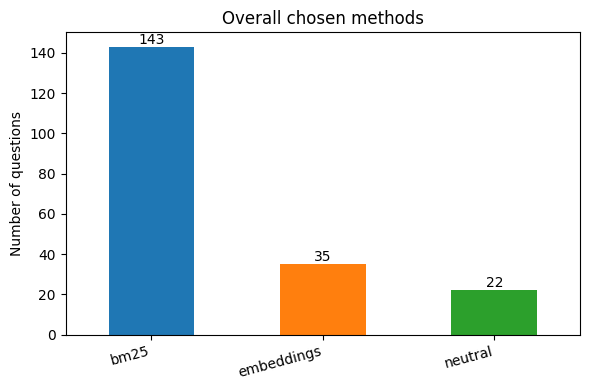

In [9]:

method_counts = df["chosen_method"].value_counts().reindex(method_order, fill_value=0)
method_share = (method_counts / method_counts.sum() * 100).round(1)
method_summary = pd.DataFrame({"count": method_counts, "share_%": method_share})
display(method_summary)

fig, ax = plt.subplots(figsize=(6, 4))
colors = [method_colors[method] for method in method_counts.index]
method_counts.plot(kind="bar", color=colors, ax=ax)
ax.set_title("Overall chosen methods")
ax.set_ylabel("Number of questions")
ax.set_xlabel("")
ax.set_xticklabels(method_counts.index, rotation=15, ha="right")
try:
    for container in ax.containers:
        ax.bar_label(container, fmt="%d")
except Exception:
    pass
plt.tight_layout()
plt.show()


### Topic-level method distribution

How often each retrieval method wins per legal topic.


chosen_method,bm25,embeddings,neutral
topic,,,
Boek 6: Algemeen gedeelte van het verbintenissenrecht,17,2,1
Boek 1: Personen- en familierecht,16,2,2
Boek 4: Erfrecht,16,3,1
Boek 10: Internationaal privaatrecht,15,2,3
Boek 5: Zakelijke rechten,15,3,2
Boek 7: Bijzondere overeenkomsten,15,4,1
Boek 3: Vermogensrecht in het algemeen,14,3,3
Boek 8: Verkeersmiddelen en vervoer,13,6,1
Boek 2: Rechtspersonen,11,8,1


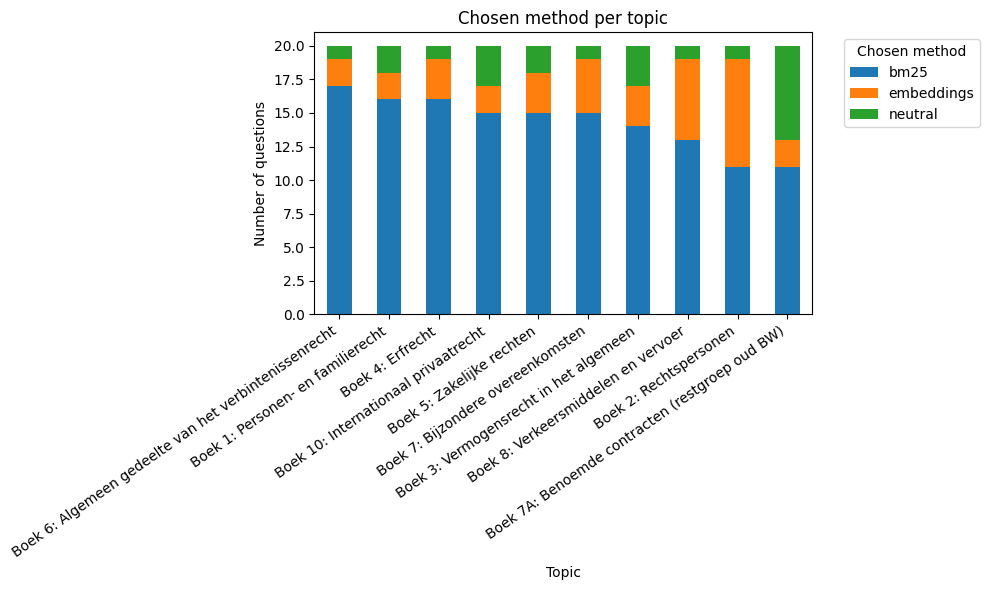

In [10]:

topic_counts = pd.crosstab(df["topic"], df["chosen_method"]).reindex(columns=method_order, fill_value=0)
topic_counts = topic_counts.sort_values(by=method_order[0], ascending=False)
display(topic_counts)

ax = topic_counts.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 6),
    color=[method_colors[method] for method in method_order],
)
ax.set_title("Chosen method per topic")
ax.set_ylabel("Number of questions")
ax.set_xlabel("Topic")
ax.legend(title="Chosen method", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=35, ha="right")
plt.tight_layout()
plt.show()


### Scenario presence and method preference

Method share split by whether the question included an explicit scenario.


chosen_method,bm25,embeddings,neutral
has_scenario_label,,,
No scenario,77.0,16.0,7.0
Scenario provided,66.0,19.0,15.0


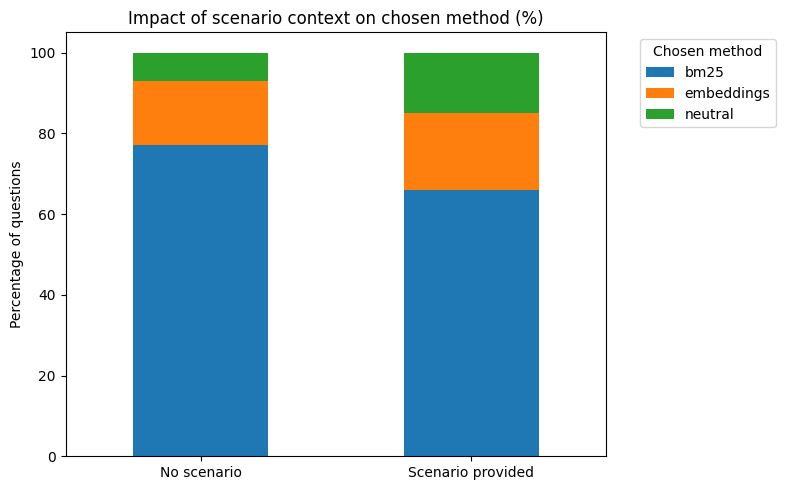

In [11]:

presence_counts = pd.crosstab(df["has_scenario_label"], df["chosen_method"]).reindex(
    columns=method_order, fill_value=0
)
presence_pct = (presence_counts.div(presence_counts.sum(axis=1), axis=0) * 100).round(1)
display(presence_pct)

ax = presence_pct.plot(
    kind="bar",
    stacked=True,
    figsize=(8, 5),
    color=[method_colors[method] for method in method_order],
)
ax.set_title("Impact of scenario context on chosen method (%)")
ax.set_ylabel("Percentage of questions")
ax.set_xlabel("")
ax.legend(title="Chosen method", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### Cumulative method trajectory

Running totals showing how each retrieval method accumulates wins through the evaluation order.


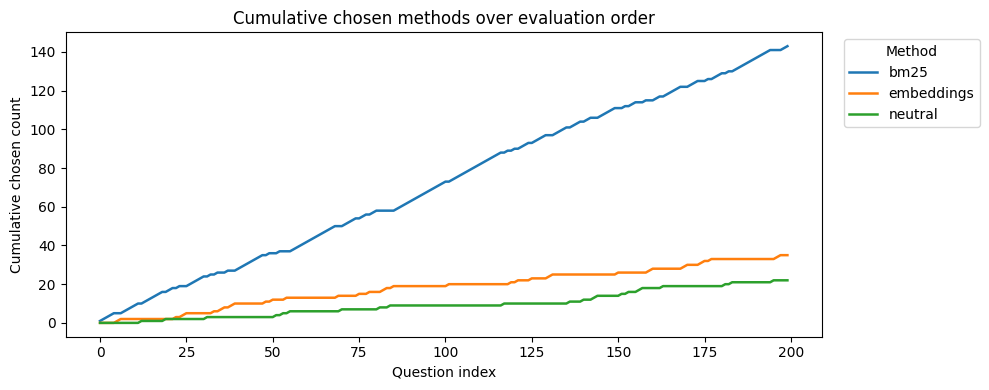

In [12]:

ordered = df.sort_values("index").copy()
dummy = pd.get_dummies(ordered["chosen_method"]).reindex(columns=method_order, fill_value=0)
cumulative_counts = dummy.cumsum()

fig, ax = plt.subplots(figsize=(10, 4))
for method in method_order:
    ax.plot(
        ordered["index"],
        cumulative_counts[method],
        label=method,
        linewidth=1.8,
        color=method_colors.get(method),
    )
ax.set_title("Cumulative chosen methods over evaluation order")
ax.set_xlabel("Question index")
ax.set_ylabel("Cumulative chosen count")
ax.legend(title="Method", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()
